# Chapter 8 - Dimensionality Reduction (Reduksi Dimensionalitas)

Bab ini membahas teknik-teknik reduksi dimensionalitas yang penting dalam Machine Learning,
termasuk PCA, Kernel PCA, dan LLE. Reduksi dimensionalitas sangat berguna untuk:
1. Mempercepat training algoritma ML
2. Visualisasi data
3. Mengatasi curse of dimensionality
4. Kompresi data

In [5]:
# Import library yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_swiss_roll, fetch_openml
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Konfigurasi matplotlib untuk tampilan yang lebih baik
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Library berhasil di-import!")

Library berhasil di-import!


## 1. Pendahuluan: Curse of Dimensionality

PENJELASAN TEORETIS:

Curse of Dimensionality adalah fenomena dimana data dengan dimensi tinggi (banyak fitur)
menjadi sangat sparse dan sulit untuk dianalisis. Beberapa masalah yang timbul:

1. Training menjadi sangat lambat
2. Sulit menemukan solusi yang baik
3. Data points menjadi sangat berjauhan satu sama lain
4. Risiko overfitting meningkat

Contoh: Dalam ruang 1D, titik random dalam unit square memiliki 0.4% kemungkinan
berada dalam jarak 0.001 dari border. Namun dalam ruang 10,000D, probabilitasnya
menjadi >99.999999%!

Solusinya adalah dengan mengurangi dimensionalitas data sambil mempertahankan
informasi penting sebanyak mungkin.

=== DEMONSTRASI CURSE OF DIMENSIONALITY ===

Dimensi    1: Jarak rata-rata = 0.3388
Dimensi    2: Jarak rata-rata = 0.5090
Dimensi    3: Jarak rata-rata = 0.6623
Dimensi   10: Jarak rata-rata = 1.2482
Dimensi  100: Jarak rata-rata = 4.0969
Dimensi 1000: Jarak rata-rata = 12.9132


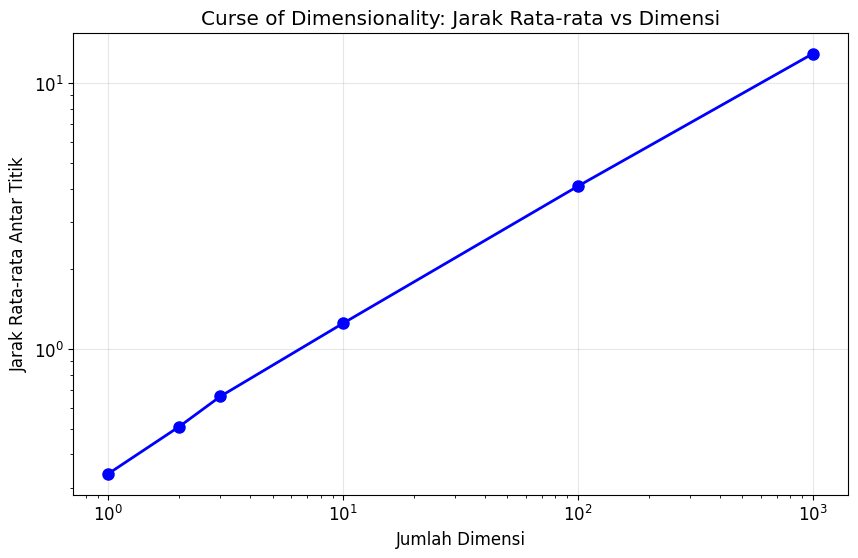

In [6]:
def demonstrate_curse_of_dimensionality():
    """
    Demonstrasi curse of dimensionality dengan menghitung jarak rata-rata
    antara titik-titik random dalam ruang dengan dimensi berbeda
    """
    print("=== DEMONSTRASI CURSE OF DIMENSIONALITY ===\n")
    
    dimensions = [1, 2, 3, 10, 100, 1000]
    n_points = 1000
    
    results = []
    
    for dim in dimensions:
        # Generate random points dalam unit hypercube
        points = np.random.random((n_points, dim))
        
        # Hitung jarak rata-rata antara semua pasangan titik
        distances = []
        for i in range(min(100, n_points)):  # Sampling untuk efisiensi
            for j in range(i+1, min(100, n_points)):
                dist = np.sqrt(np.sum((points[i] - points[j])**2))
                distances.append(dist)
        
        avg_distance = np.mean(distances)
        results.append(avg_distance)
        
        print(f"Dimensi {dim:4d}: Jarak rata-rata = {avg_distance:.4f}")
    
    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.plot(dimensions, results, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Jumlah Dimensi')
    plt.ylabel('Jarak Rata-rata Antar Titik')
    plt.title('Curse of Dimensionality: Jarak Rata-rata vs Dimensi')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
    
    return results

# Jalankan demonstrasi
curse_results = demonstrate_curse_of_dimensionality()

## 2. Pendekatan Utama untuk Reduksi Dimensionalitas

"""
PENJELASAN TEORETIS:

Ada dua pendekatan utama untuk reduksi dimensionalitas:

1. PROJECTION (Proyeksi):
   - Memproyeksikan data ke subspace dengan dimensi lebih rendah
   - Cocok untuk data yang terletak pada atau dekat hyperplane
   - Contoh: PCA, Random Projection

2. MANIFOLD LEARNING:
   - Memodelkan manifold dimana data berada
   - Cocok untuk data yang membentuk struktur non-linear kompleks
   - Contoh: LLE, Isomap, t-SNE
   - Berdasarkan manifold assumption: data high-dimensional sebenarnya
     terletak pada manifold dengan dimensi lebih rendah

Manifold adalah struktur geometris yang secara lokal menyerupai ruang Euclidean
dengan dimensi lebih rendah. Contoh: permukaan bola (2D manifold dalam ruang 3D).


=== DEMONSTRASI SWISS ROLL DATASET ===



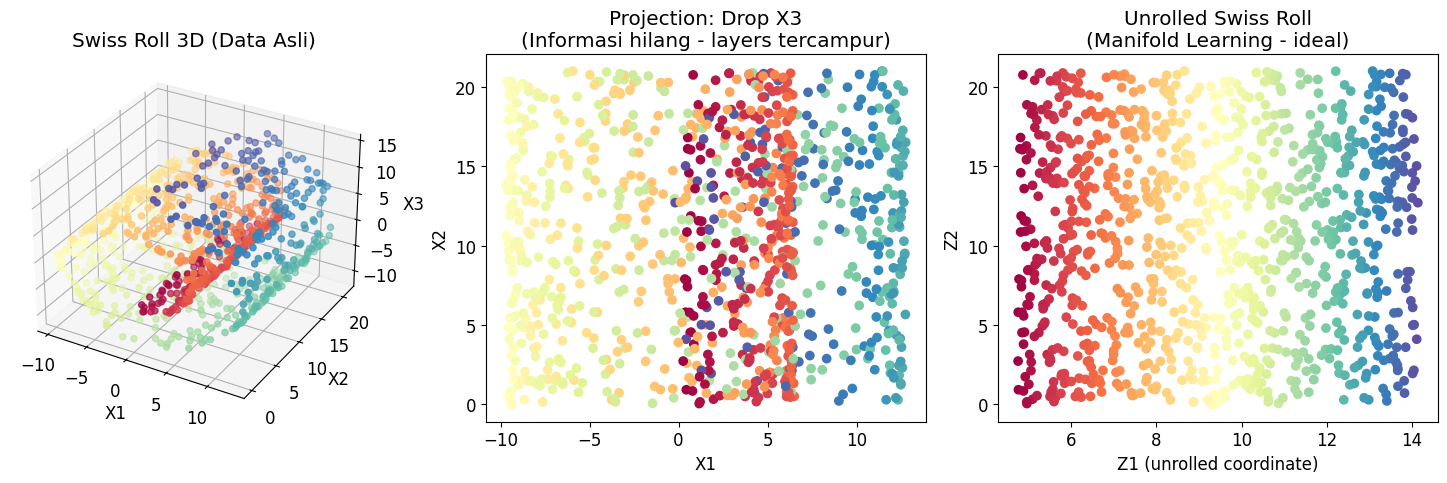

In [7]:
# Generate Swiss Roll dataset untuk demonstrasi
def create_swiss_roll_demo():
    """
    Membuat Swiss Roll dataset untuk mendemonstrasikan perbedaan
    antara projection dan manifold learning
    """
    print("\n=== DEMONSTRASI SWISS ROLL DATASET ===\n")
    
    # Generate Swiss Roll data
    X, color = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)
    
    # Visualisasi 3D
    fig = plt.figure(figsize=(15, 5))
    
    # Swiss Roll 3D
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax1.set_title('Swiss Roll 3D (Data Asli)')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('X3')
    
    # Projection (menghilangkan X3)
    ax2 = fig.add_subplot(132)
    ax2.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax2.set_title('Projection: Drop X3\n(Informasi hilang - layers tercampur)')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    
    # Unrolled (ideal result)
    ax3 = fig.add_subplot(133)
    ax3.scatter(color, X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax3.set_title('Unrolled Swiss Roll\n(Manifold Learning - ideal)')
    ax3.set_xlabel('Z1 (unrolled coordinate)')
    ax3.set_ylabel('Z2')
    
    plt.tight_layout()
    plt.show()
    
    return X, color

# Create Swiss Roll demo
X_swiss, color_swiss = create_swiss_roll_demo()

## 3. Principal Component Analysis (PCA)

"""
PENJELASAN TEORETIS:

PCA adalah algoritma reduksi dimensionalitas yang paling populer. Cara kerjanya:

1. PRESERVING THE VARIANCE:
   - Mencari hyperplane yang paling dekat dengan data
   - Memproyeksikan data ke hyperplane tersebut
   - Memilih axis yang mempertahankan variance maksimum

2. PRINCIPAL COMPONENTS:
   - PC ke-i adalah axis yang menjelaskan variance terbesar ke-i
   - Semua PC saling orthogonal (tegak lurus)
   - PC pertama menjelaskan variance terbesar, PC kedua variance terbesar kedua, dst.

3. MATHEMATICAL FOUNDATION:
   - Menggunakan Singular Value Decomposition (SVD)
   - X = U Σ V^T
   - Matrix V berisi unit vectors yang mendefinisikan principal components

4. LANGKAH-LANGKAH PCA:
   - Center data (mean = 0)
   - Hitung covariance matrix
   - Eigen decomposition / SVD
   - Pilih k eigenvectors dengan eigenvalues terbesar
   - Project data ke subspace yang dibentuk k eigenvectors tersebut

KEUNTUNGAN:
- Cepat dan efisien
- Mempertahankan variance maksimum
- Tidak supervised (unsupervised)
- Bisa di-inverse (approximate reconstruction)

KEKURANGAN:
- Linear transformation saja
- Semua PC harus dihitung untuk mendapatkan subset
- Interpretability bisa berkurang


=== DEMONSTRASI KONSEP PCA ===

Principal Component 1: [-0.959, -0.282]
Principal Component 2: [0.282, -0.959]
Variance explained by PC1: 74.7%
Variance explained by PC2: 25.3%


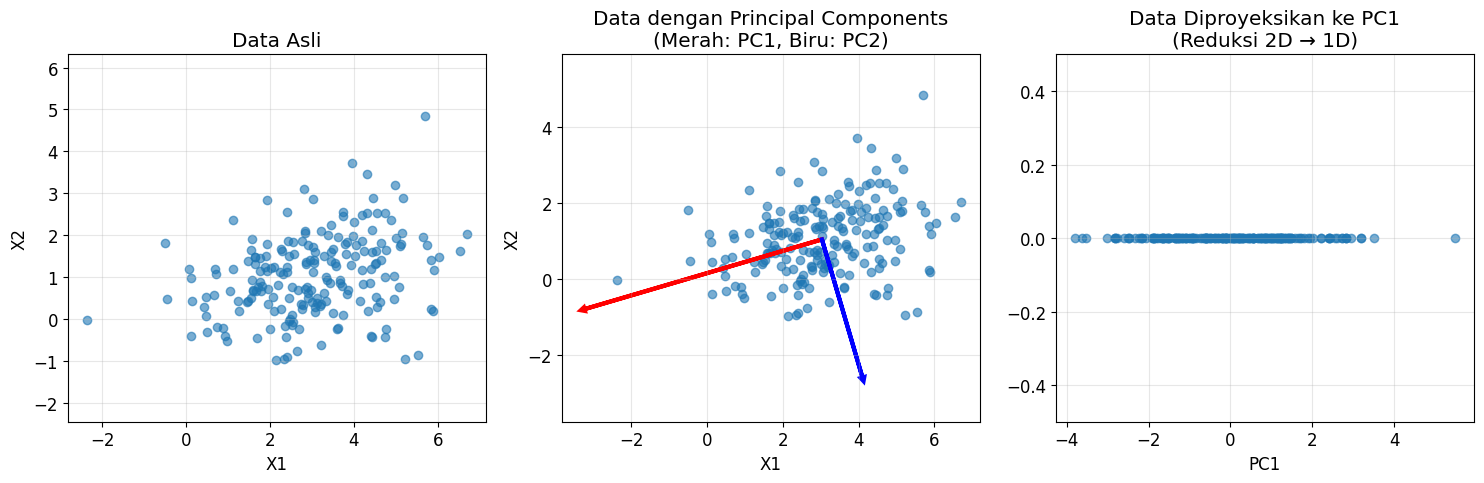

In [9]:
def demonstrate_pca_concept():
    """
    Demonstrasi konsep dasar PCA dengan dataset 2D sederhana
    """
    print("\n=== DEMONSTRASI KONSEP PCA ===\n")
    
    # Generate data 2D dengan korelasi
    np.random.seed(42)
    m = 200
    X = np.random.randn(m, 2)
    X = X.dot(np.array([[1.5, 0], [0.5, 1]]))  # Transform untuk korelasi
    X = X + np.array([3, 1])  # Shift mean
    
    # Manual PCA calculation
    X_centered = X - X.mean(axis=0)
    U, s, Vt = np.linalg.svd(X_centered)
    
    # Principal components (unit vectors)
    pc1 = Vt.T[:, 0]  # First principal component
    pc2 = Vt.T[:, 1]  # Second principal component
    
    print(f"Principal Component 1: [{pc1[0]:.3f}, {pc1[1]:.3f}]")
    print(f"Principal Component 2: [{pc2[0]:.3f}, {pc2[1]:.3f}]")
    print(f"Variance explained by PC1: {(s[0]**2 / (s**2).sum()):.1%}")
    print(f"Variance explained by PC2: {(s[1]**2 / (s**2).sum()):.1%}")
    
    # Visualisasi
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original data
    axes[0].scatter(X[:, 0], X[:, 1], alpha=0.6)
    axes[0].set_title('Data Asli')
    axes[0].set_xlabel('X1')
    axes[0].set_ylabel('X2')
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    
    # Data with principal components
    axes[1].scatter(X[:, 0], X[:, 1], alpha=0.6)
    
    # Plot principal component vectors
    mean_point = X.mean(axis=0)
    axes[1].arrow(mean_point[0], mean_point[1], 
                  pc1[0]*s[0]*0.3, pc1[1]*s[0]*0.3,
                  head_width=0.1, head_length=0.1, fc='red', ec='red', linewidth=3)
    axes[1].arrow(mean_point[0], mean_point[1], 
                  pc2[0]*s[1]*0.3, pc2[1]*s[1]*0.3,
                  head_width=0.1, head_length=0.1, fc='blue', ec='blue', linewidth=3)
    
    axes[1].set_title('Data dengan Principal Components\n(Merah: PC1, Biru: PC2)')
    axes[1].set_xlabel('X1')
    axes[1].set_ylabel('X2')
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    
    # Projected data (1D)
    X_projected = X_centered.dot(pc1.reshape(-1, 1))
    axes[2].scatter(X_projected, np.zeros_like(X_projected), alpha=0.6)
    axes[2].set_title('Data Diproyeksikan ke PC1\n(Reduksi 2D → 1D)')
    axes[2].set_xlabel('PC1')
    axes[2].set_ylim(-0.5, 0.5)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return X, X_centered, pc1, pc2

# Demonstrate PCA concept
X_demo, X_centered_demo, pc1_demo, pc2_demo = demonstrate_pca_concept()

## 4. Implementasi PCA dengan Scikit-Learn

"""
PENJELASAN TEORETIS:

Scikit-Learn menyediakan implementasi PCA yang mudah digunakan dengan berbagai fitur:

1. AUTOMATIC CENTERING: Data secara otomatis di-center
2. EXPLAINED VARIANCE RATIO: Proporsi variance yang dijelaskan setiap PC
3. FLEXIBLE N_COMPONENTS: Bisa integer (jumlah PC) atau float (rasio variance)
4. INVERSE TRANSFORM: Bisa reconstruct data (approximate)

PARAMETER PENTING:
- n_components: Jumlah PC atau rasio variance yang dipertahankan
- svd_solver: 'auto', 'full', 'randomized'
- whiten: Standardisasi PC (variance = 1)


=== DEMONSTRASI PCA DENGAN SCIKIT-LEARN ===

Loading MNIST dataset...
Original data shape: (5000, 784)
Original data size: 3920000 elements
Jumlah komponen untuk 95% variance: 148
Jumlah komponen untuk 99% variance: 322
Reduced data shape: (5000, 148)
Compression ratio: 18.9%
Actual variance preserved: 95.0%


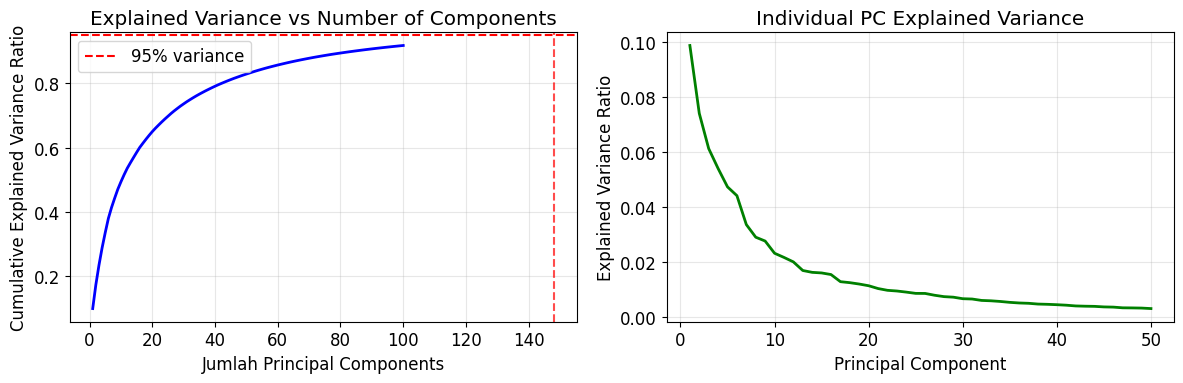

In [10]:
def demonstrate_pca_sklearn():
    """
    Demonstrasi PCA menggunakan Scikit-Learn dengan MNIST dataset
    """
    print("\n=== DEMONSTRASI PCA DENGAN SCIKIT-LEARN ===\n")
    
    # Load MNIST dataset (sample kecil untuk demo)
    print("Loading MNIST dataset...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist.data[:5000], mnist.target[:5000]  # Sample untuk demo
    
    # Standardize data
    X = X / 255.0  # Normalize pixel values
    
    print(f"Original data shape: {X.shape}")
    print(f"Original data size: {X.size} elements")
    
    # Apply PCA tanpa reduction (untuk analisis)
    pca_full = PCA()
    pca_full.fit(X)
    
    # Explained variance ratio
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    
    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
    
    print(f"Jumlah komponen untuk 95% variance: {n_components_95}")
    print(f"Jumlah komponen untuk 99% variance: {np.argmax(cumsum_var >= 0.99) + 1}")
    
    # Apply PCA dengan 95% variance
    pca = PCA(n_components=0.95)
    X_reduced = pca.fit_transform(X)
    
    print(f"Reduced data shape: {X_reduced.shape}")
    print(f"Compression ratio: {X_reduced.size / X.size:.1%}")
    print(f"Actual variance preserved: {pca.explained_variance_ratio_.sum():.1%}")
    
    # Visualisasi explained variance
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, min(101, len(cumsum_var)+1)), cumsum_var[:100], 'b-', linewidth=2)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    plt.axvline(x=n_components_95, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Jumlah Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance vs Number of Components')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, min(51, len(pca_full.explained_variance_ratio_)+1)), 
             pca_full.explained_variance_ratio_[:50], 'g-', linewidth=2)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Individual PC Explained Variance')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return X, X_reduced, pca

# Demonstrate PCA with sklearn
X_mnist, X_mnist_reduced, pca_mnist = demonstrate_pca_sklearn()

## 5. PCA untuk Kompresi dan Rekonstruksi

"""
PENJELASAN TEORETIS:

PCA dapat digunakan untuk kompresi data dengan cara:

1. COMPRESSION: Reduksi dimensionalitas → ukuran data lebih kecil
2. DECOMPRESSION: Inverse transform → rekonstruksi data asli (approximate)
3. RECONSTRUCTION ERROR: MSE antara data asli dan rekonstruksi

KEGUNAAN:
- Kompresi gambar
- Noise reduction
- Data preprocessing
- Visualisasi

TRADE-OFF:
- Kompresi ratio vs kualitas rekonstruksi
- Speed vs accuracy


=== DEMONSTRASI PCA UNTUK KOMPRESI ===

Variance 50%: 3 components, compression 0.4%, MSE 0.0261
Variance 80%: 6 components, compression 0.8%, MSE 0.0087
Variance 95%: 8 components, compression 1.0%, MSE 0.0012
Variance 99%: 9 components, compression 1.1%, MSE 0.0000


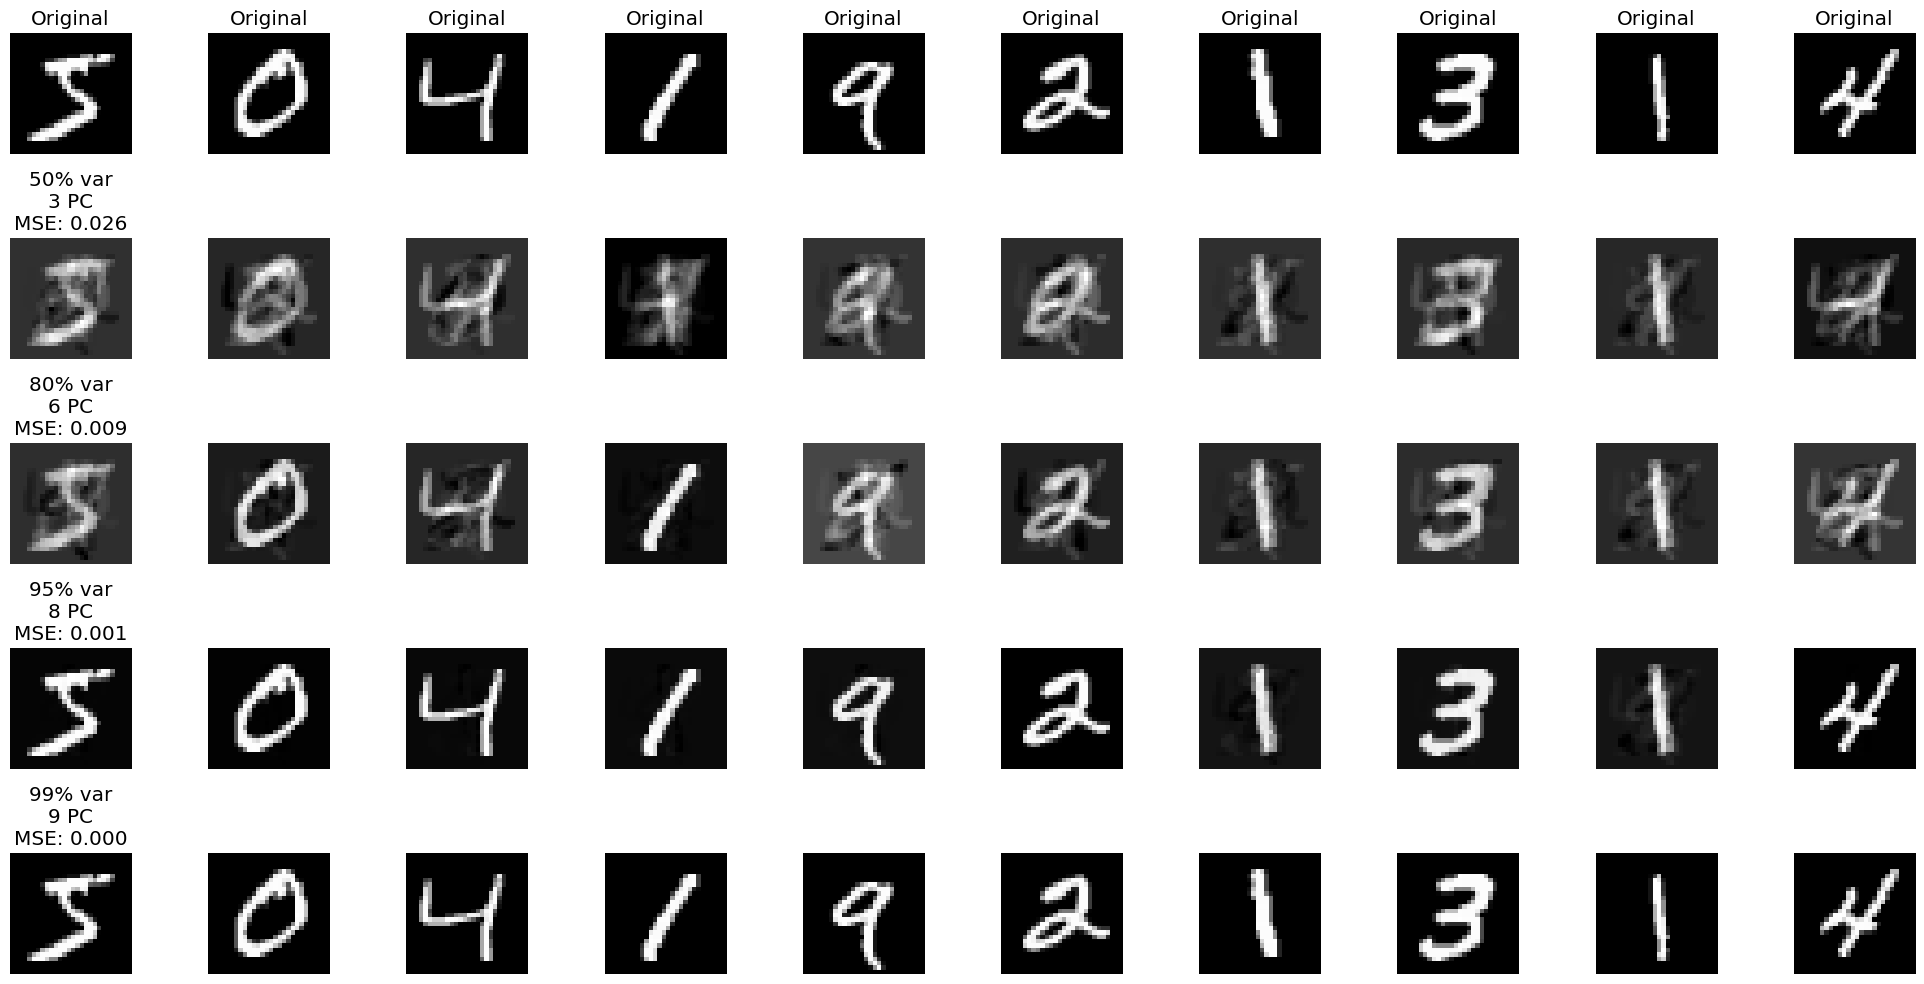

In [11]:
def demonstrate_pca_compression():
    """
    Demonstrasi kompresi dan rekonstruksi menggunakan PCA
    """
    print("\n=== DEMONSTRASI PCA UNTUK KOMPRESI ===\n")
    
    # Gunakan subset MNIST untuk visualisasi
    n_samples = 10
    X_sample = X_mnist[:n_samples]
    
    # Test berbagai level kompresi
    compression_levels = [0.50, 0.80, 0.95, 0.99]
    
    fig, axes = plt.subplots(len(compression_levels) + 1, n_samples, 
                            figsize=(n_samples*2, (len(compression_levels)+1)*2))
    
    # Original images
    for i in range(n_samples):
        axes[0, i].imshow(X_sample[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'Original')
        axes[0, i].axis('off')
    
    # Compressed and reconstructed images
    for comp_idx, variance_ratio in enumerate(compression_levels):
        pca_comp = PCA(n_components=variance_ratio)
        X_compressed = pca_comp.fit_transform(X_sample)
        X_reconstructed = pca_comp.inverse_transform(X_compressed)
        
        # Calculate compression info
        original_size = X_sample.size
        compressed_size = X_compressed.size
        compression_ratio = compressed_size / original_size
        mse = mean_squared_error(X_sample, X_reconstructed)
        
        print(f"Variance {variance_ratio:.0%}: {pca_comp.n_components_} components, "
              f"compression {compression_ratio:.1%}, MSE {mse:.4f}")
        
        for i in range(n_samples):
            axes[comp_idx + 1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
            if i == 0:
                axes[comp_idx + 1, i].set_title(f'{variance_ratio:.0%} var\n'
                                              f'{pca_comp.n_components_} PC\n'
                                              f'MSE: {mse:.3f}')
            axes[comp_idx + 1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Demonstrate PCA compression
demonstrate_pca_compression()

## 6. Randomized PCA dan Incremental PCA

"""
PENJELASAN TEORETIS:

1. RANDOMIZED PCA:
   - Menggunakan algoritma stokastik untuk aproksimasi PC
   - Kompleksitas: O(m × d²) + O(d³) vs O(m × n²) + O(n³)
   - Jauh lebih cepat ketika d << n
   - Otomatis digunakan ketika m atau n > 500 dan d < 80% dari min(m,n)

2. INCREMENTAL PCA (IPCA):
   - Memproses data dalam mini-batches
   - Berguna untuk dataset yang tidak muat dalam memory
   - Bisa digunakan untuk online learning
   - Kompleksitas memory: O(batch_size × n) + O(d × n)

KAPAN MENGGUNAKAN:
- Randomized PCA: Dataset besar, dimensi target kecil
- Incremental PCA: Dataset sangat besar, memory terbatas
- Standard PCA: Dataset kecil-sedang yang muat dalam memory

In [12]:
def demonstrate_advanced_pca():
    """
    Demonstrasi Randomized PCA dan Incremental PCA
    """
    print("\n=== DEMONSTRASI RANDOMIZED PCA DAN INCREMENTAL PCA ===\n")
    
    # Generate larger dataset for timing comparison
    np.random.seed(42)
    n_samples, n_features = 2000, 100
    X_large = np.random.randn(n_samples, n_features)
    
    # Standard PCA
    import time
    
    print("Perbandingan waktu eksekusi:")
    
    # Standard PCA timing
    start_time = time.time()
    pca_standard = PCA(n_components=20)
    X_pca_standard = pca_standard.fit_transform(X_large)
    time_standard = time.time() - start_time
    print(f"Standard PCA: {time_standard:.3f} seconds")
    
    # Randomized PCA timing
    start_time = time.time()
    pca_randomized = PCA(n_components=20, svd_solver='randomized')
    X_pca_randomized = pca_randomized.fit_transform(X_large)
    time_randomized = time.time() - start_time
    print(f"Randomized PCA: {time_randomized:.3f} seconds")
    
    # Incremental PCA
    start_time = time.time()
    inc_pca = IncrementalPCA(n_components=20, batch_size=100)
    X_pca_incremental = inc_pca.fit_transform(X_large)
    time_incremental = time.time() - start_time
    print(f"Incremental PCA: {time_incremental:.3f} seconds")
    
    # Compare results (should be similar)
    mse_rand = mean_squared_error(X_pca_standard, X_pca_randomized)
    mse_inc = mean_squared_error(X_pca_standard, X_pca_incremental)
    
    print(f"\nAccuracy comparison (MSE with Standard PCA):")
    print(f"Randomized PCA MSE: {mse_rand:.6f}")
    print(f"Incremental PCA MSE: {mse_inc:.6f}")
    
    # Demonstrate Incremental PCA with batches
    print(f"\nDemonstrasi Incremental PCA dengan batches:")
    inc_pca_batch = IncrementalPCA(n_components=20)
    
    # Process in batches
    batch_size = 500
    for i in range(0, n_samples, batch_size):
        batch = X_large[i:i+batch_size]
        inc_pca_batch.partial_fit(batch)
        print(f"  Processed batch {i//batch_size + 1}, size: {len(batch)}")
    
    # Transform all data
    X_pca_batch = inc_pca_batch.transform(X_large)
    mse_batch = mean_squared_error(X_pca_standard, X_pca_batch)
    print(f"Batch processing MSE: {mse_batch:.6f}")
    
    return pca_standard, pca_randomized, inc_pca

# Demonstrate advanced PCA
pca_std, pca_rand, pca_inc = demonstrate_advanced_pca()


=== DEMONSTRASI RANDOMIZED PCA DAN INCREMENTAL PCA ===

Perbandingan waktu eksekusi:
Standard PCA: 0.007 seconds
Randomized PCA: 0.026 seconds
Incremental PCA: 0.254 seconds

Accuracy comparison (MSE with Standard PCA):
Randomized PCA MSE: 2.817090
Incremental PCA MSE: 2.326254

Demonstrasi Incremental PCA dengan batches:
  Processed batch 1, size: 500
  Processed batch 2, size: 500
  Processed batch 3, size: 500
  Processed batch 4, size: 500
Batch processing MSE: 2.635900


## 7. Kernel PCA

"""
PENJELASAN TEORETIS:

Kernel PCA menerapkan kernel trick pada PCA, memungkinkan proyeksi non-linear:

1. KONSEP DASAR:
   - Mapping data ke feature space berdimensi tinggi (bahkan infinite)
   - Menerapkan PCA linear di feature space
   - Hasil: proyeksi non-linear di space asli

2. KERNEL FUNCTIONS:
   - Linear: K(x,y) = x^T y
   - RBF/Gaussian: K(x,y) = exp(-γ||x-y||²)
   - Polynomial: K(x,y) = (γx^T y + r)^d
   - Sigmoid: K(x,y) = tanh(γx^T y + r)

3. KEUNTUNGAN:
   - Dapat menangani struktur non-linear
   - Baik untuk unrolling manifolds
   - Preserves clusters after projection

4. KEKURANGAN:
   - Lebih kompleks secara komputasi
   - Sulit di-interpret
   - Hyperparameter tuning diperlukan
   - Tidak ada inverse transform langsung

5. RECONSTRUCTION PRE-IMAGE:
   - Karena feature space infinite-dimensional, tidak bisa langsung inverse
   - Perlu cari pre-image di space asli yang map ke titik rekonstruksi
   - Scikit-learn menggunakan kernel ridge regression untuk ini


=== DEMONSTRASI KERNEL PCA ===

Demonstrasi rekonstruksi dengan RBF Kernel PCA:
Reconstruction error (MSE): 31.7412


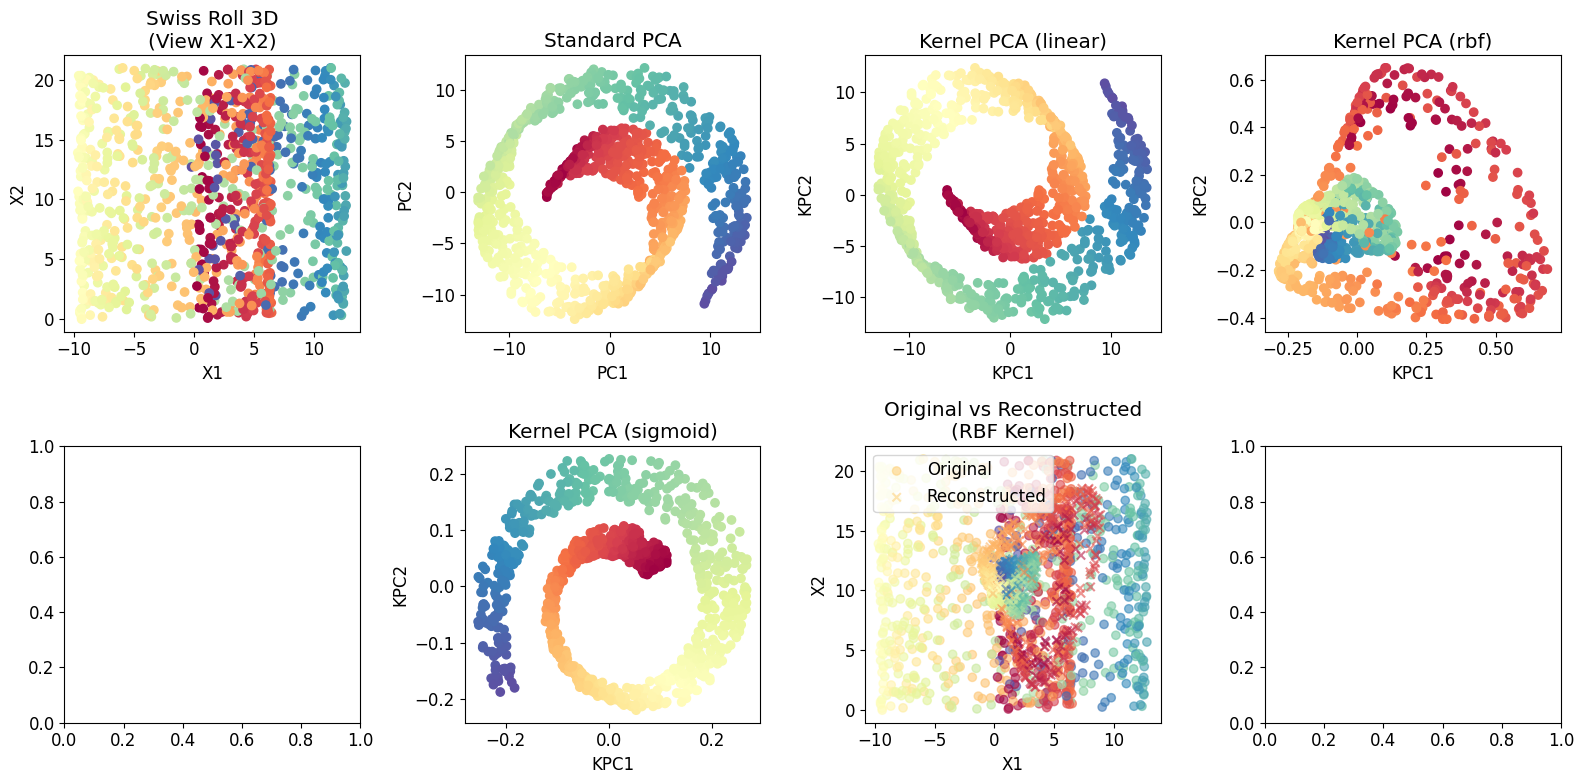

In [13]:
def demonstrate_kernel_pca():
    """
    Demonstrasi Kernel PCA dengan berbagai kernel pada Swiss Roll
    """
    print("\n=== DEMONSTRASI KERNEL PCA ===\n")
    
    # Generate Swiss Roll dataset
    X_swiss_kpca, color_swiss_kpca = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)
    
    # Different kernels to test
    kernels = ['linear', 'rbf', 'sigmoid']
    kernel_params = [
        {},  # linear
        {'gamma': 0.04},  # rbf
        {'gamma': 0.001}  # sigmoid
    ]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Original 3D data
    ax = axes[0, 0]
    ax.scatter(X_swiss_kpca[:, 0], X_swiss_kpca[:, 1], c=color_swiss_kpca, cmap=plt.cm.Spectral)
    ax.set_title('Swiss Roll 3D\n(View X1-X2)')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    
    # Standard PCA for comparison
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_swiss_kpca)
    ax = axes[0, 1]
    ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=color_swiss_kpca, cmap=plt.cm.Spectral)
    ax.set_title('Standard PCA')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
    # Kernel PCA with different kernels
    for i, (kernel, params) in enumerate(zip(kernels, kernel_params)):
        kpca = KernelPCA(n_components=2, kernel=kernel, **params)
        X_kpca = kpca.fit_transform(X_swiss_kpca)
        
        ax = axes[0, i+2] if i < 2 else axes[1, i-1]
        ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c=color_swiss_kpca, cmap=plt.cm.Spectral)
        ax.set_title(f'Kernel PCA ({kernel})')
        ax.set_xlabel('KPC1')
        ax.set_ylabel('KPC2')
    
    # Demonstrate reconstruction with RBF kernel
    print("Demonstrasi rekonstruksi dengan RBF Kernel PCA:")
    kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=0.04, 
                         fit_inverse_transform=True)
    X_kpca_rbf = kpca_rbf.fit_transform(X_swiss_kpca)
    X_reconstructed = kpca_rbf.inverse_transform(X_kpca_rbf)
    
    # Calculate reconstruction error
    reconstruction_error = mean_squared_error(X_swiss_kpca, X_reconstructed)
    print(f"Reconstruction error (MSE): {reconstruction_error:.4f}")
    
    # Plot original vs reconstructed
    ax = axes[1, 2]
    ax.scatter(X_swiss_kpca[:, 0], X_swiss_kpca[:, 1], 
               c=color_swiss_kpca, cmap=plt.cm.Spectral, alpha=0.6, label='Original')
    ax.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], 
               c=color_swiss_kpca, cmap=plt.cm.Spectral, alpha=0.6, 
               marker='x', label='Reconstructed')
    ax.set_title('Original vs Reconstructed\n(RBF Kernel)')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return X_kpca_rbf, kpca_rbf

# Demonstrate Kernel PCA
X_kpca_result, kpca_model = demonstrate_kernel_pca()

## 8. Hyperparameter Tuning untuk Kernel PCA

"""
PENJELASAN TEORETIS:

Karena Kernel PCA adalah unsupervised, tidak ada performance measure yang jelas.
Beberapa strategi untuk tuning:

1. SUPERVISED APPROACH:
   - Gunakan dalam pipeline dengan supervised algorithm
   - Grid search pada performance downstream task
   - Contoh: kPCA → Logistic Regression → accuracy

2. UNSUPERVISED APPROACH:
   - Minimize reconstruction pre-image error
   - Cross-validation pada reconstruction error
   - Visual inspection untuk clustering/visualization tasks

3. HYPERPARAMETERS:
   - kernel: 'linear', 'rbf', 'poly', 'sigmoid'
   - gamma: untuk RBF, poly, sigmoid kernels
   - degree: untuk polynomial kernel
   - coef0: untuk poly dan sigmoid kernels


=== HYPERPARAMETER TUNING UNTUK KERNEL PCA ===

Grid Search untuk Kernel PCA + Logistic Regression:
Best parameters: {'kpca__gamma': 0.1, 'kpca__kernel': 'rbf'}
Best cross-validation score: 0.710
Standard PCA + Logistic Regression CV score: 0.584 ± 0.011
Best Kernel PCA + Logistic Regression CV score: 0.710


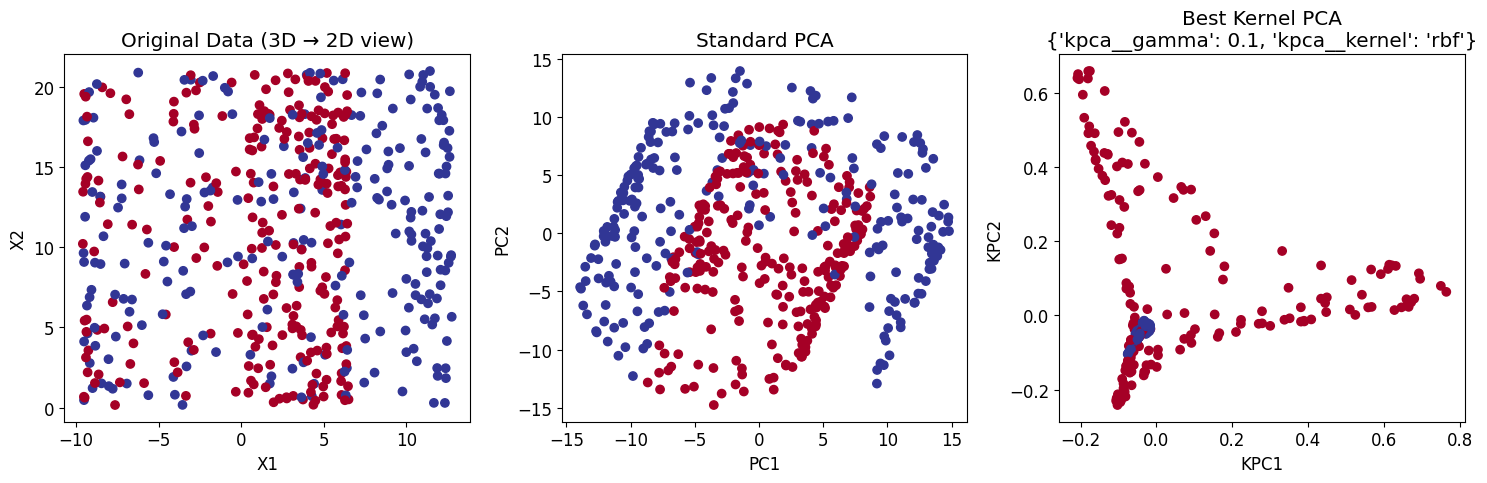

In [14]:
def demonstrate_kernel_pca_tuning():
    """
    Demonstrasi hyperparameter tuning untuk Kernel PCA
    """
    print("\n=== HYPERPARAMETER TUNING UNTUK KERNEL PCA ===\n")
    
    # Create a classification dataset from Swiss Roll
    X_class = X_swiss[:500]  # Smaller sample for speed
    # Create binary classification based on position
    y_class = (color_swiss[:500] > np.median(color_swiss[:500])).astype(int)
    
    print("Grid Search untuk Kernel PCA + Logistic Regression:")
    
    # Create pipeline
    pipe = Pipeline([
        ('kpca', KernelPCA(n_components=2)),
        ('logistic', LogisticRegression(max_iter=1000))
    ])
    
    # Parameter grid
    param_grid = [
        {
            'kpca__kernel': ['rbf'],
            'kpca__gamma': [0.01, 0.03, 0.1, 0.3]
        },
        {
            'kpca__kernel': ['poly'],
            'kpca__degree': [2, 3, 4],
            'kpca__gamma': [0.01, 0.1]
        }
    ]
    
    # Grid search
    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_class, y_class)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    # Compare with standard PCA
    pipe_pca = Pipeline([
        ('pca', PCA(n_components=2)),
        ('logistic', LogisticRegression(max_iter=1000))
    ])
    
    from sklearn.model_selection import cross_val_score
    pca_scores = cross_val_score(pipe_pca, X_class, y_class, cv=3, scoring='accuracy')
    
    print(f"Standard PCA + Logistic Regression CV score: {pca_scores.mean():.3f} ± {pca_scores.std():.3f}")
    print(f"Best Kernel PCA + Logistic Regression CV score: {grid_search.best_score_:.3f}")
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original data
    axes[0].scatter(X_class[:, 0], X_class[:, 1], c=y_class, cmap='RdYlBu')
    axes[0].set_title('Original Data (3D → 2D view)')
    axes[0].set_xlabel('X1')
    axes[0].set_ylabel('X2')
    
    # Standard PCA
    pca_viz = PCA(n_components=2)
    X_pca_viz = pca_viz.fit_transform(X_class)
    axes[1].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], c=y_class, cmap='RdYlBu')
    axes[1].set_title('Standard PCA')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    
    # Best Kernel PCA
    best_kpca = KernelPCA(n_components=2, **{k.replace('kpca__', ''): v 
                                           for k, v in grid_search.best_params_.items() 
                                           if k.startswith('kpca__')})
    X_best_kpca = best_kpca.fit_transform(X_class)
    axes[2].scatter(X_best_kpca[:, 0], X_best_kpca[:, 1], c=y_class, cmap='RdYlBu')
    axes[2].set_title(f'Best Kernel PCA\n{grid_search.best_params_}')
    axes[2].set_xlabel('KPC1')
    axes[2].set_ylabel('KPC2')
    
    plt.tight_layout()
    plt.show()
    
    return grid_search

# Demonstrate hyperparameter tuning
best_kpca_model = demonstrate_kernel_pca_tuning()

## 9. Locally Linear Embedding (LLE)

"""
PENJELASAN TEORETIS:

LLE adalah teknik manifold learning yang powerful untuk non-linear dimensionality reduction:

1. ALGORITMA LLE:
   Step 1: Untuk setiap instance x^(i), cari k nearest neighbors
   Step 2: Cari weights w_{i,j} yang merekonstruksi x^(i) dari neighbors:
           minimize Σ ||x^(i) - Σ w_{i,j} x^(j)||²
           subject to: Σ w_{i,j} = 1, w_{i,j} = 0 jika x^(j) bukan neighbor
   
   Step 3: Map ke d-dimensional space sambil preserve relationships:
           minimize Σ ||z^(i) - Σ w_{i,j} z^(j)||²
           dimana z^(i) adalah peta x^(i) di ruang d-dimensi

2. INTUISI:
   - Local linear relationships dipertahankan
   - Global non-linear structure bisa di-unroll
   - Baik untuk twisted manifolds

3. KEUNTUNGAN:
   - Excellent untuk unrolling manifolds
   - Preserve local distances
   - Non-linear dimensionality reduction

4. KEKURANGAN:
   - Sensitif terhadap noise
   - Computational complexity: O(d*m²) → tidak scalable
   - Perlu tuning k (number of neighbors)
   - Tidak ada out-of-sample extension

5. PARAMETER PENTING:
   - n_neighbors: jumlah nearest neighbors (k)
   - n_components: dimensi target
   - reg: regularization parameter
"""


=== DEMONSTRASI LOCALLY LINEAR EMBEDDING (LLE) ===

Menerapkan LLE pada Swiss Roll dataset...
LLE dengan k=5: reconstruction error = 0.0000
LLE dengan k=10: reconstruction error = 0.0000
LLE dengan k=15: reconstruction error = 0.0000
LLE dengan k=20: reconstruction error = 0.0000


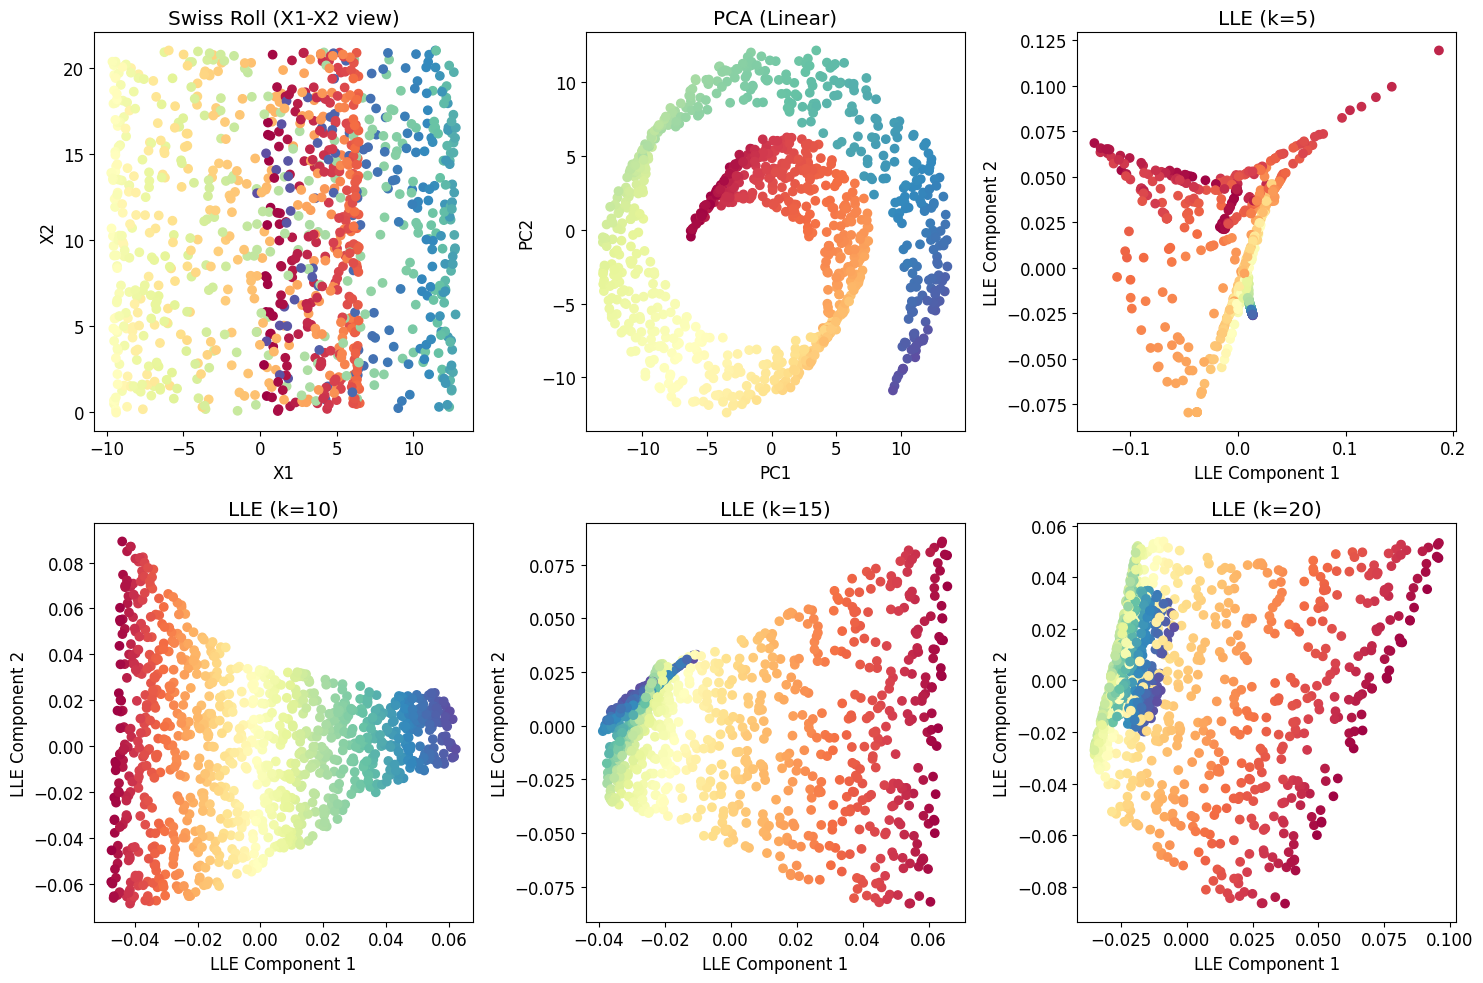


LLE berhasil 'unroll' Swiss Roll!
Reconstruction error dengan k=10: 0.0000


In [15]:
def demonstrate_lle():
    """
    Demonstrasi Locally Linear Embedding (LLE)
    """
    print("\n=== DEMONSTRASI LOCALLY LINEAR EMBEDDING (LLE) ===\n")
    
    # Generate Swiss Roll for LLE demo
    X_lle, color_lle = make_swiss_roll(n_samples=1000, noise=0.1, random_state=42)
    
    print("Menerapkan LLE pada Swiss Roll dataset...")
    
    # Try different number of neighbors
    n_neighbors_list = [5, 10, 15, 20]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original Swiss Roll (3D view)
    axes[0, 0].scatter(X_lle[:, 0], X_lle[:, 1], c=color_lle, cmap=plt.cm.Spectral)
    axes[0, 0].set_title('Swiss Roll (X1-X2 view)')
    axes[0, 0].set_xlabel('X1')
    axes[0, 0].set_ylabel('X2')
    
    # Standard PCA comparison
    pca_lle = PCA(n_components=2)
    X_pca_lle = pca_lle.fit_transform(X_lle)
    axes[0, 1].scatter(X_pca_lle[:, 0], X_pca_lle[:, 1], c=color_lle, cmap=plt.cm.Spectral)
    axes[0, 1].set_title('PCA (Linear)')
    axes[0, 1].set_xlabel('PC1')
    axes[0, 1].set_ylabel('PC2')
    
    # LLE with different n_neighbors
    for i, n_neighbors in enumerate(n_neighbors_list):
        lle = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors, random_state=42)
        X_lle_transformed = lle.fit_transform(X_lle)
        
        row = 0 if i < 2 else 1
        col = 2 if i == 0 else (0 if i == 1 else (i-1 if i < 4 else i-2))
        if i >= 2:
            col = i - 2
        
        # Handle subplot indexing
        if i == 0:
            ax = axes[0, 2]
        elif i == 1:
            ax = axes[1, 0]
        elif i == 2:
            ax = axes[1, 1]
        else:
            ax = axes[1, 2]
        
        ax.scatter(X_lle_transformed[:, 0], X_lle_transformed[:, 1], 
                   c=color_lle, cmap=plt.cm.Spectral)
        ax.set_title(f'LLE (k={n_neighbors})')
        ax.set_xlabel('LLE Component 1')
        ax.set_ylabel('LLE Component 2')
        
        # Calculate reconstruction error
        reconstruction_error = lle.reconstruction_error_
        print(f"LLE dengan k={n_neighbors}: reconstruction error = {reconstruction_error:.4f}")
    
    plt.tight_layout()
    plt.show()
    
    # Best LLE result
    best_lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
    X_lle_best = best_lle.fit_transform(X_lle)
    
    print(f"\nLLE berhasil 'unroll' Swiss Roll!")
    print(f"Reconstruction error dengan k=10: {best_lle.reconstruction_error_:.4f}")
    
    return X_lle_best, best_lle

# Demonstrate LLE
X_lle_result, lle_model = demonstrate_lle()

## 10. Perbandingan Teknik Dimensionality Reduction

"""
PENJELASAN TEORETIS:

RINGKASAN PERBANDINGAN TEKNIK:

1. PCA (Principal Component Analysis):
   - Linear, cepat, preserve variance
   - Baik untuk: preprocessing, compression, visualization
   - Buruk untuk: non-linear structures

2. Kernel PCA:
   - Non-linear extension of PCA
   - Baik untuk: complex non-linear structures, clustering
   - Buruk untuk: interpretability, computational cost

3. LLE (Locally Linear Embedding):
   - Excellent untuk manifolds, preserve local structure
   - Baik untuk: unrolling twisted manifolds
   - Buruk untuk: noise sensitivity, scalability

4. Other techniques:
   - t-SNE: visualization, clustering
   - Isomap: geodesic distances on manifolds
   - MDS: preserve pairwise distances
   - Random Projection: fast, distance preservation

PEMILIHAN TEKNIK:
- Dataset size: PCA > Kernel PCA > LLE
- Linear structure: PCA
- Non-linear structure: Kernel PCA, LLE, t-SNE
- Visualization: t-SNE, LLE
- Preprocessing: PCA, Random Projection
- Interpretability: PCA > others
"""


=== PERBANDINGAN TEKNIK DIMENSIONALITY REDUCTION ===

Linear + PCA: 0.001s
Linear + Kernel PCA (RBF): 0.004s
Linear + LLE: 0.064s
Swiss Roll + PCA: 0.001s
Swiss Roll + Kernel PCA (RBF): 0.004s
Swiss Roll + LLE: 0.028s
S-Curve + PCA: 0.001s
S-Curve + Kernel PCA (RBF): 0.003s
S-Curve + LLE: 0.055s


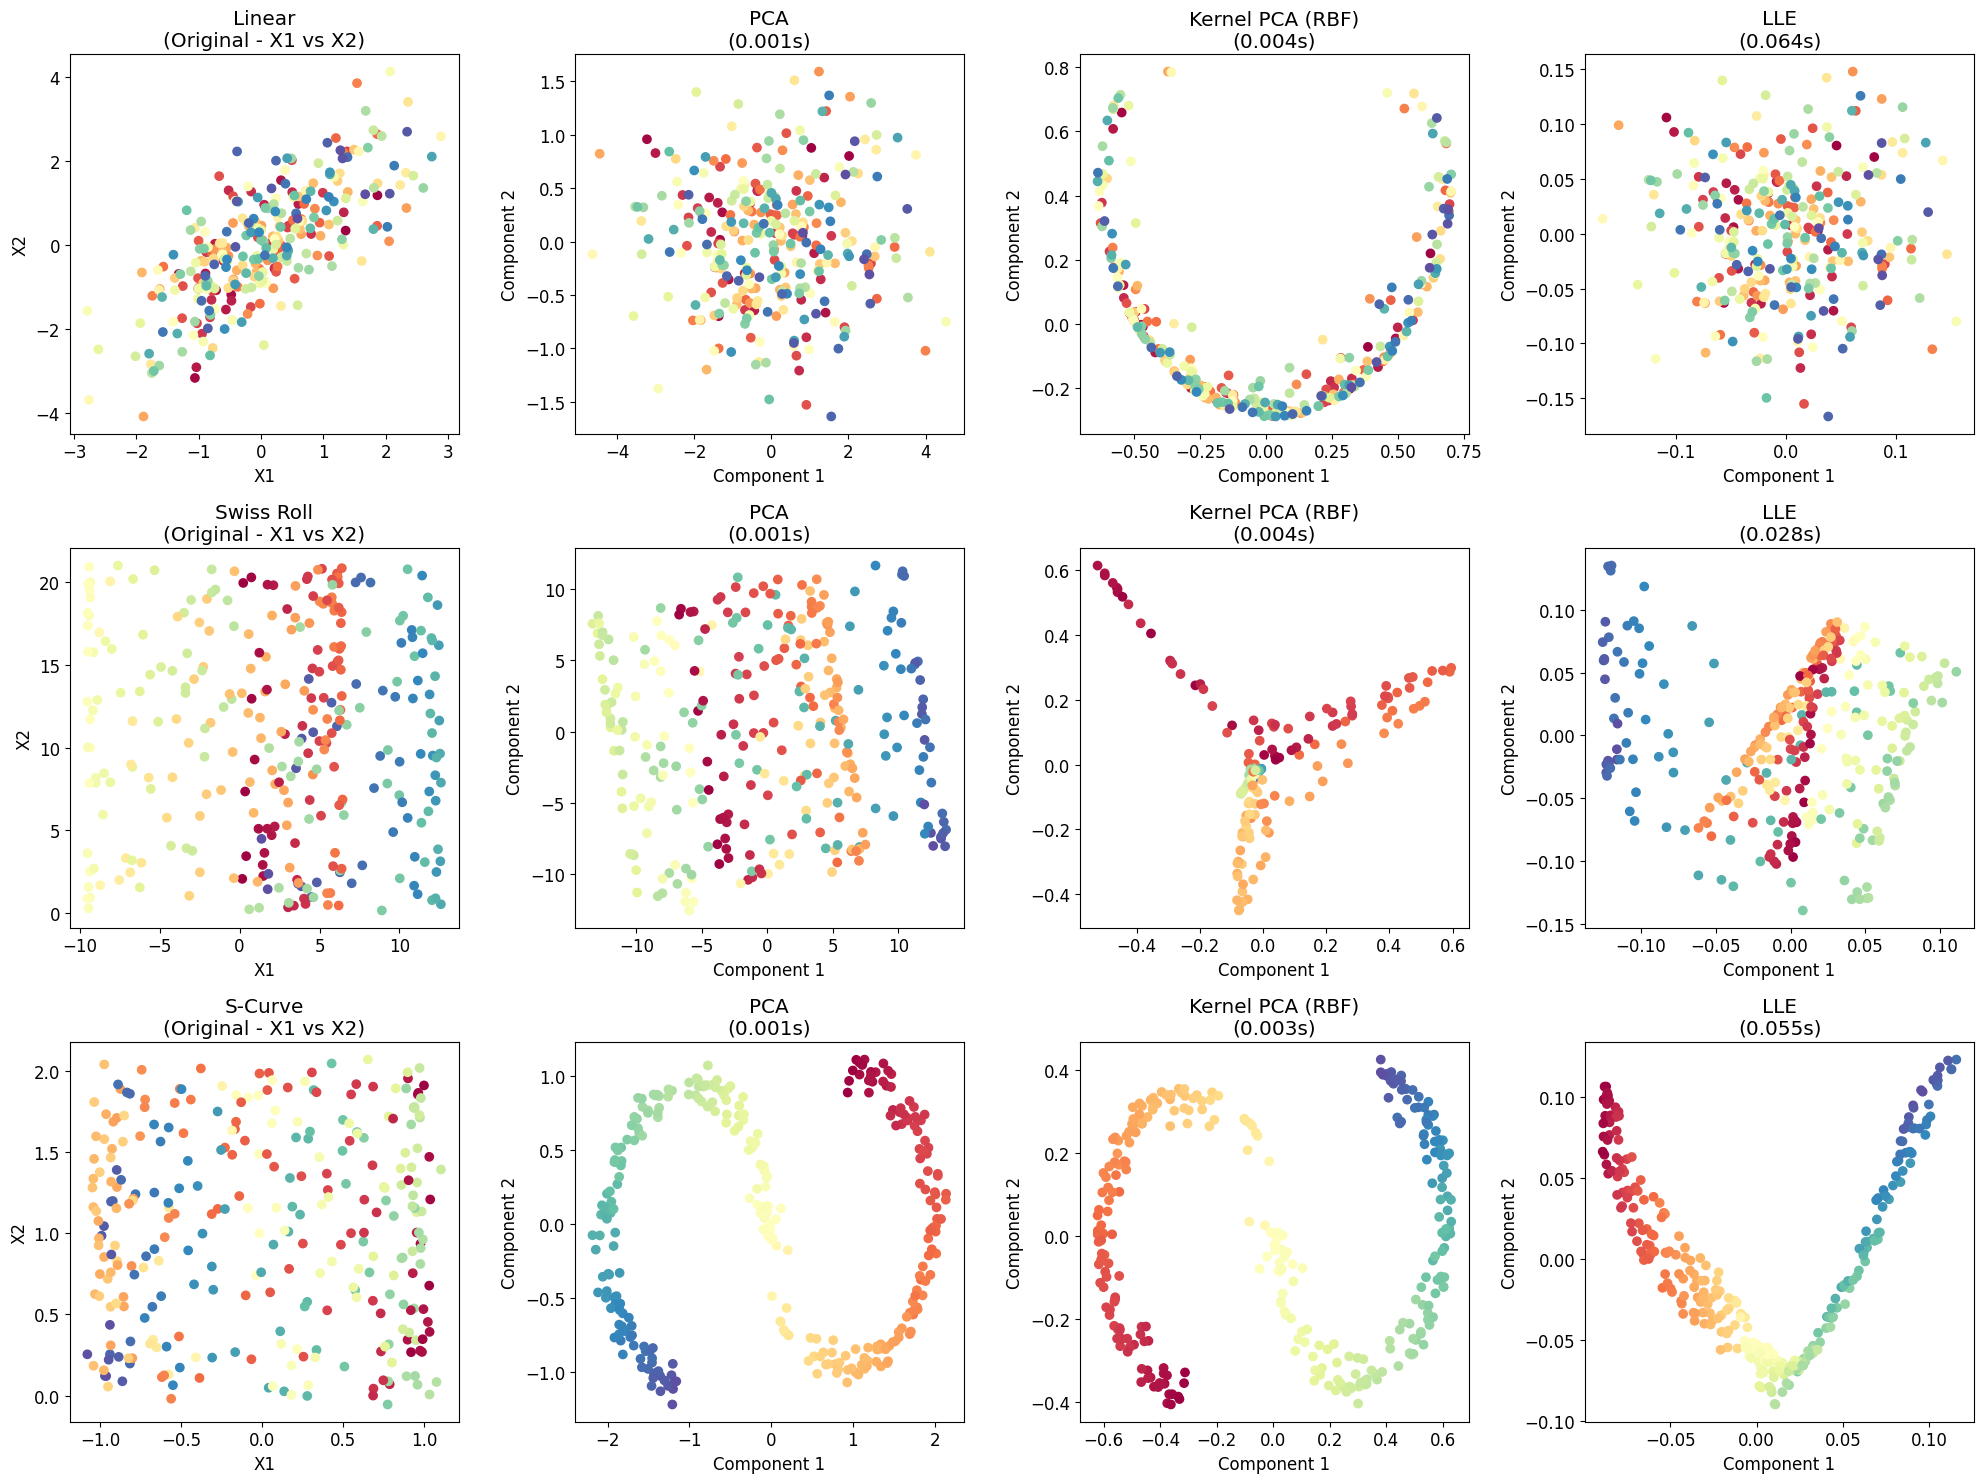


RINGKASAN PERFORMA:
Dataset        | PCA    | Kernel PCA | LLE
------------------------------------------------------------
Linear         |  0.001s |  0.003s |  0.048s |
Swiss Roll     |  0.002s |  0.020s |  0.031s |
S-Curve        |  0.001s |  0.003s |  0.034s |


In [18]:
def compare_dimensionality_reduction_techniques():
    """
    Perbandingan berbagai teknik dimensionality reduction
    """
    print("\n=== PERBANDINGAN TEKNIK DIMENSIONALITY REDUCTION ===\n")
    
    # Create different types of datasets
    datasets = {}
    
    # Linear dataset
    np.random.seed(42)
    X_linear = np.random.randn(300, 3)
    X_linear = X_linear.dot(np.array([[1, 0.5], [0.5, 1], [0.2, 0.8]]))
    datasets['Linear'] = (X_linear, np.arange(len(X_linear)))
    
    # Swiss Roll (non-linear manifold)
    X_swiss_comp, color_swiss_comp = make_swiss_roll(n_samples=300, noise=0.05, random_state=42)
    datasets['Swiss Roll'] = (X_swiss_comp, color_swiss_comp)
    
    # S-Curve (another manifold)
    from sklearn.datasets import make_s_curve
    X_s_curve, color_s_curve = make_s_curve(n_samples=300, noise=0.05, random_state=42)
    datasets['S-Curve'] = (X_s_curve, color_s_curve)
    
    # Dimensionality reduction techniques
    techniques = {
        'PCA': PCA(n_components=2),
        'Kernel PCA (RBF)': KernelPCA(n_components=2, kernel='rbf', gamma=0.1),
        'LLE': LocallyLinearEmbedding(n_components=2, n_neighbors=12)
    }
    
    # Compare techniques
    fig, axes = plt.subplots(len(datasets), len(techniques) + 1, 
                            figsize=(20, 5*len(datasets)))
    
    for i, (dataset_name, (X, color)) in enumerate(datasets.items()):
        # Original data (3D -> 2D projection for visualization)
        axes[i, 0].scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
        axes[i, 0].set_title(f'{dataset_name}\n(Original - X1 vs X2)')
        axes[i, 0].set_xlabel('X1')
        axes[i, 0].set_ylabel('X2')
        
        # Apply each technique
        for j, (technique_name, model) in enumerate(techniques.items()):
            try:
                import time
                start_time = time.time()
                X_transformed = model.fit_transform(X)
                exec_time = time.time() - start_time
                
                axes[i, j+1].scatter(X_transformed[:, 0], X_transformed[:, 1], 
                                   c=color, cmap=plt.cm.Spectral)
                axes[i, j+1].set_title(f'{technique_name}\n({exec_time:.3f}s)')
                axes[i, j+1].set_xlabel('Component 1')
                axes[i, j+1].set_ylabel('Component 2')
                
                print(f"{dataset_name} + {technique_name}: {exec_time:.3f}s")
                
            except Exception as e:
                axes[i, j+1].text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', 
                                transform=axes[i, j+1].transAxes, ha='center', va='center')
                axes[i, j+1].set_title(f'{technique_name}\n(Failed)')
    
    plt.tight_layout()
    plt.show()
    
    # Performance summary
    print("\n" + "="*60)
    print("RINGKASAN PERFORMA:")
    print("="*60)
    print("Dataset        | PCA    | Kernel PCA | LLE")
    print("-"*60)
    
    for dataset_name, (X, color) in datasets.items():
        print(f"{dataset_name:14} |", end="")
        
        for technique_name, model in techniques.items():
            try:
                import time
                start_time = time.time()
                model.fit_transform(X)
                exec_time = time.time() - start_time
                print(f" {exec_time:6.3f}s |", end="")
            except:
                print(f" Failed |", end="")
        print()

# Compare techniques
compare_dimensionality_reduction_techniques()

## 11. Panduan Praktis Memilih Teknik

"""
PANDUAN PRAKTIS MEMILIH TEKNIK DIMENSIONALITY REDUCTION:

1. UKURAN DATASET:
   - Kecil (< 1000 samples): Semua teknik OK
   - Sedang (1K-10K): PCA, Kernel PCA, LLE dengan hati-hati
   - Besar (> 10K): PCA, Incremental PCA, Random Projection

2. JENIS STRUKTUR DATA:
   - Linear/hampir linear: PCA
   - Non-linear tapi smooth manifold: LLE, Isomap
   - Complex non-linear: Kernel PCA, t-SNE
   - Tidak tahu: Coba PCA dulu

3. TUJUAN:
   - Preprocessing/speed up: PCA, Random Projection
   - Visualization: t-SNE, LLE
   - Compression: PCA
   - Noise reduction: PCA
   - Clustering preservation: Kernel PCA, t-SNE

4. COMPUTATIONAL RESOURCES:
   - Terbatas: PCA, Random Projection
   - Sedang: Kernel PCA
   - Banyak: LLE, t-SNE

5. INTERPRETABILITY:
   - Perlu interpretable: PCA
   - Tidak masalah: Kernel PCA, LLE, t-SNE

6. OUT-OF-SAMPLE:
   - Perlu transform data baru: PCA, Kernel PCA
   - Tidak perlu: LLE, t-SNE

In [19]:
def create_practical_guide():
    """
    Membuat panduan praktis pemilihan teknik
    """
    print("\n=== PANDUAN PRAKTIS PEMILIHAN TEKNIK ===\n")
    
    # Decision tree style guide
    decision_guide = """
    DECISION TREE UNTUK MEMILIH TEKNIK:
    
    1. Apakah dataset Anda besar (>10K samples)?
       YES → Gunakan PCA atau Incremental PCA
       NO  → Lanjut ke step 2
    
    2. Apakah Anda butuh hasil yang interpretable?
       YES → Gunakan PCA
       NO  → Lanjut ke step 3
    
    3. Apakah tujuan utama untuk visualisasi?
       YES → Coba t-SNE atau LLE
       NO  → Lanjut ke step 4
    
    4. Apakah data Anda memiliki struktur non-linear yang kompleks?
       YES → Coba Kernel PCA dengan RBF kernel
       NO  → Gunakan PCA
    
    5. Apakah Anda perlu transform data baru di kemudian hari?
       YES → Hindari LLE, gunakan PCA atau Kernel PCA
       NO  → Semua teknik OK
    """
    
    print(decision_guide)
    
    # Performance comparison table
    comparison_data = {
        'Technique': ['PCA', 'Kernel PCA', 'LLE', 't-SNE', 'Random Projection'],
        'Speed': ['Fast', 'Medium', 'Slow', 'Slow', 'Very Fast'],
        'Scalability': ['Excellent', 'Good', 'Poor', 'Poor', 'Excellent'],
        'Non-linear': ['No', 'Yes', 'Yes', 'Yes', 'No'],
        'Interpretability': ['High', 'Low', 'Low', 'Low', 'Medium'],
        'Out-of-sample': ['Yes', 'Yes', 'No', 'No', 'Yes'],
        'Use Case': ['General', 'Complex data', 'Manifolds', 'Visualization', 'Preprocessing']
    }
    
    df_comparison = pd.DataFrame(comparison_data)
    print("\nTABEL PERBANDINGAN TEKNIK:")
    print("="*80)
    print(df_comparison.to_string(index=False))
    
    return df_comparison

# Create practical guide
guide_df = create_practical_guide()


=== PANDUAN PRAKTIS PEMILIHAN TEKNIK ===


    DECISION TREE UNTUK MEMILIH TEKNIK:

    1. Apakah dataset Anda besar (>10K samples)?
       YES → Gunakan PCA atau Incremental PCA
       NO  → Lanjut ke step 2

    2. Apakah Anda butuh hasil yang interpretable?
       YES → Gunakan PCA
       NO  → Lanjut ke step 3

    3. Apakah tujuan utama untuk visualisasi?
       YES → Coba t-SNE atau LLE
       NO  → Lanjut ke step 4

    4. Apakah data Anda memiliki struktur non-linear yang kompleks?
       YES → Coba Kernel PCA dengan RBF kernel
       NO  → Gunakan PCA

    5. Apakah Anda perlu transform data baru di kemudian hari?
       YES → Hindari LLE, gunakan PCA atau Kernel PCA
       NO  → Semua teknik OK
    

TABEL PERBANDINGAN TEKNIK:
        Technique     Speed Scalability Non-linear Interpretability Out-of-sample      Use Case
              PCA      Fast   Excellent         No             High           Yes       General
       Kernel PCA    Medium        Good        Yes          

## 12. Kesimpulan dan Best Practices

"""
KESIMPULAN CHAPTER 8 - DIMENSIONALITY REDUCTION:

1. KAPAN MENGGUNAKAN DIMENSIONALITY REDUCTION:
   - Training terlalu lambat
   - Curse of dimensionality
   - Visualisasi data
   - Kompresi/storage efficiency
   - Noise reduction

2. JANGAN GUNAKAN JIKA:
   - Dataset sudah kecil dan training cepat
   - Interpretability features sangat penting
   - Risk information loss tidak acceptable

3. WORKFLOW YANG DIREKOMENDASIKAN:
   a. Coba training tanpa dimensionality reduction dulu
   b. Jika terlalu lambat, coba PCA dengan 95% variance
   c. Jika data non-linear, coba Kernel PCA
   d. Untuk visualization, coba t-SNE atau LLE
   e. Selalu evaluate impact pada downstream task

4. BEST PRACTICES:
   - Selalu standardize/normalize data sebelum PCA
   - Gunakan explained variance ratio untuk pilih n_components
   - Cross-validate untuk hyperparameter tuning
   - Monitor reconstruction error
   - Evaluate impact pada final model performance

5. COMMON PITFALLS:
   - Applying DR tanpa cek apakah perlu
   - Tidak standardize data
   - Terlalu agresif reduce dimensions
   - Tidak evaluate impact pada downstream task
   - Menggunakan teknik yang salah untuk jenis data


=== DEMONSTRASI WORKFLOW LENGKAP ===

1. Loading dan preprocessing dataset...
   Original shape: (2000, 784)

2. Analisis explained variance...
   Components untuk 95% variance: 141
   Components untuk 99% variance: 304

3. Menerapkan PCA dengan 95% variance...
   Reduced shape: (2000, 141)
   Compression ratio: 18.0%

4. Test rekonstruksi...
   Reconstruction MSE: 0.003303

5. Visualisasi hasil...


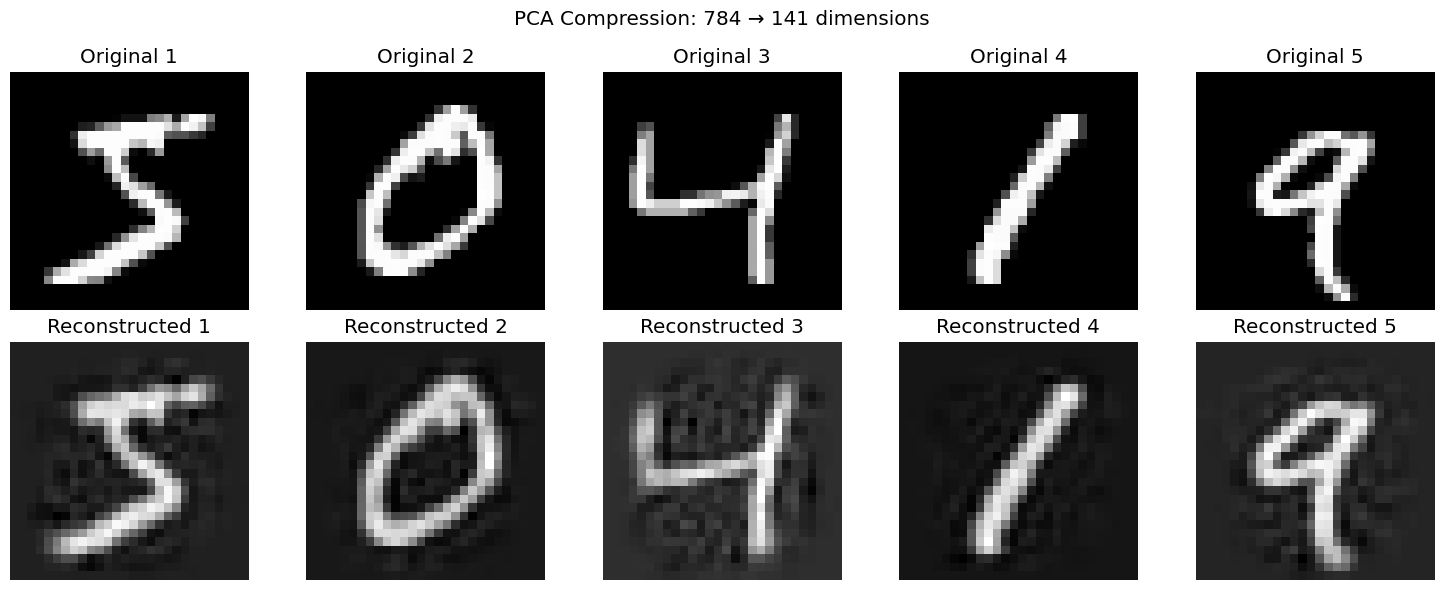


6. Workflow selesai!
   ✓ Data berhasil dikompres dari 784 ke 141 dimensi
   ✓ Variance yang dipertahankan: 95.0%
   ✓ Ukuran data berkurang menjadi 18.0% dari aslinya

CHAPTER 8 - DIMENSIONALITY REDUCTION SELESAI!
Anda telah mempelajari:
✓ Curse of dimensionality dan solusinya
✓ PCA: konsep, implementasi, dan variasi (Randomized, Incremental)
✓ Kernel PCA untuk non-linear dimensionality reduction
✓ LLE untuk manifold learning
✓ Perbandingan berbagai teknik
✓ Best practices dan panduan pemilihan teknik
✓ Workflow lengkap dimensionality reduction

Selamat! Anda siap menerapkan dimensionality reduction dalam project ML Anda!


In [20]:
def final_demonstration():
    """
    Demonstrasi final: workflow lengkap dimensionality reduction
    """
    print("\n=== DEMONSTRASI WORKFLOW LENGKAP ===\n")
    
    # Load dataset
    print("1. Loading dan preprocessing dataset...")
    mnist_small = fetch_openml('mnist_784', version=1, as_frame=False)
    X_final, y_final = mnist_small.data[:2000], mnist_small.target[:2000]
    X_final = X_final / 255.0  # Normalize
    
    print(f"   Original shape: {X_final.shape}")
    
    # Step 2: Analyze variance
    print("\n2. Analisis explained variance...")
    pca_analysis = PCA()
    pca_analysis.fit(X_final)
    
    cumsum_var = np.cumsum(pca_analysis.explained_variance_ratio_)
    n_95 = np.argmax(cumsum_var >= 0.95) + 1
    n_99 = np.argmax(cumsum_var >= 0.99) + 1
    
    print(f"   Components untuk 95% variance: {n_95}")
    print(f"   Components untuk 99% variance: {n_99}")
    
    # Step 3: Apply PCA
    print(f"\n3. Menerapkan PCA dengan 95% variance...")
    pca_final = PCA(n_components=0.95)
    X_reduced_final = pca_final.fit_transform(X_final)
    
    print(f"   Reduced shape: {X_reduced_final.shape}")
    print(f"   Compression ratio: {X_reduced_final.size / X_final.size:.1%}")
    
    # Step 4: Reconstruction
    print(f"\n4. Test rekonstruksi...")
    X_reconstructed_final = pca_final.inverse_transform(X_reduced_final)
    mse_final = mean_squared_error(X_final, X_reconstructed_final)
    
    print(f"   Reconstruction MSE: {mse_final:.6f}")
    
    # Step 5: Visualize results
    print(f"\n5. Visualisasi hasil...")
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    # Original images
    for i in range(5):
        axes[0, i].imshow(X_final[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(X_reconstructed_final[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')
    
    plt.suptitle(f'PCA Compression: {X_final.shape[1]} → {X_reduced_final.shape[1]} dimensions')
    plt.tight_layout()
    plt.show()
    
    print(f"\n6. Workflow selesai!")
    print(f"   ✓ Data berhasil dikompres dari {X_final.shape[1]} ke {X_reduced_final.shape[1]} dimensi")
    print(f"   ✓ Variance yang dipertahankan: {pca_final.explained_variance_ratio_.sum():.1%}")
    print(f"   ✓ Ukuran data berkurang menjadi {X_reduced_final.size / X_final.size:.1%} dari aslinya")
    
    return X_final, X_reduced_final, X_reconstructed_final

# Final demonstration
X_original, X_reduced, X_reconstructed = final_demonstration()

print("\n" + "="*80)
print("CHAPTER 8 - DIMENSIONALITY REDUCTION SELESAI!")
print("="*80)
print("Anda telah mempelajari:")
print("✓ Curse of dimensionality dan solusinya")  
print("✓ PCA: konsep, implementasi, dan variasi (Randomized, Incremental)")
print("✓ Kernel PCA untuk non-linear dimensionality reduction")
print("✓ LLE untuk manifold learning")
print("✓ Perbandingan berbagai teknik")
print("✓ Best practices dan panduan pemilihan teknik")
print("✓ Workflow lengkap dimensionality reduction")
print("\nSelamat! Anda siap menerapkan dimensionality reduction dalam project ML Anda!")